# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CMSC723
CROWD = "project_materials/umd_reddit_suicidewatch_dataset_v2/crowd"
EXPERT = "project_materials/umd_reddit_suicidewatch_dataset_v2/expert"

/content/drive/MyDrive/CMSC723


# Read Data

In [ ]:
import pandas as pd
from os.path import join

crowd_meta = pd.read_csv(join(CROWD, "train", "crowd_train.csv"))
crowd_posts = pd.read_csv(join(CROWD, "train", "shared_task_posts.csv"))
expert_meta = pd.read_csv(join(EXPERT, "expert.csv"))
expert_posts = pd.read_csv(join(EXPERT, "expert_posts.csv"))

## Replace NaNs

In [ ]:
crowd_meta["label"].fillna(value="NA", inplace=True)
expert_meta["label"].fillna(value="NA", inplace=True)

# EDA

## Labels

Before we dive deeper into the data, we may want to get a quick look at how crowd and expert labels are distributed. 

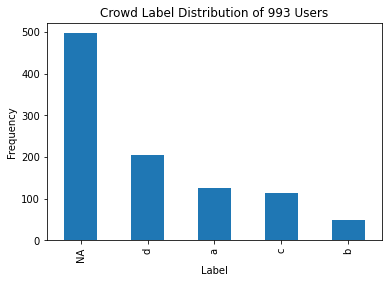

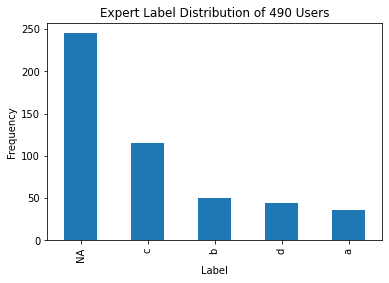

In [ ]:
from matplotlib import pyplot as plt

crowd_meta["label"].value_counts().plot.bar()
plt.title(f"Crowd Label Distribution of {crowd_meta['user_id'].nunique()} Users")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

expert_meta["label"].value_counts().plot.bar()
plt.title(f"Expert Label Distribution of {expert_meta['user_id'].nunique()} Users")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

We can see that crowd users are more likely to use the extreme labels $\{a, d\}$ and expert users are more likely to use the less extreme labels $\{b, c\}$ to classify reddit users' suicidality. This may mean that a model trained on crowd data may classify expert labeled data at a more extreme severity.

Let's see what this distribution looks like if we consider a binary label of high $\{c, d\}$ vs low severity $\{a, b\}$

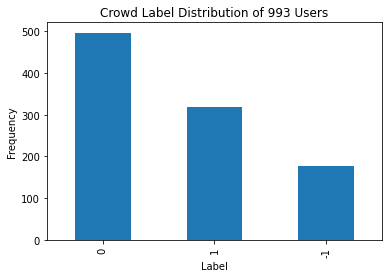

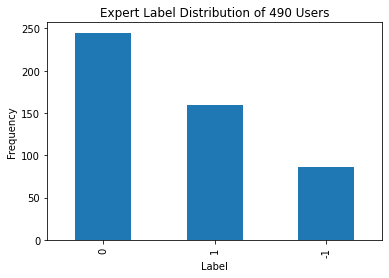

In [ ]:
crowd_meta["high_severity"] = (((crowd_meta["label"] == "d") | 
                                (crowd_meta["label"] == "c")).astype("int") - 
                               ((crowd_meta["label"] == "a") |
                                (crowd_meta["label"] == "b")))
crowd_meta["high_severity"].value_counts().plot.bar()
plt.title(f"Crowd Label Distribution of {crowd_meta['user_id'].nunique()} Users")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

expert_meta["high_severity"] = (((expert_meta["label"] == "d") | 
                                 (expert_meta["label"] == "c")).astype("int") - 
                                ((expert_meta["label"] == "a") |
                                 (expert_meta["label"] == "b")))
expert_meta["high_severity"].value_counts().plot.bar()
plt.title(f"Expert Label Distribution of {expert_meta['user_id'].nunique()} Users")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

We can see that by applying this transformation, the expert label distributions and crowd label distributions are more similar. It may make sense to use this transformation in our future model as well.

## Posts

In [ ]:
print(f"There are {crowd_posts.shape[0]} posts for crowd labeled data")
print(f"There are {expert_posts.shape[0]} posts for expert labeled data")

There are 2038753 posts for crowd labeled data
There are 49417 posts for expert labeled data


There are over 2 Million posts in the Crowd labeled dataset and almost 50000 posts in the Expert labeled dataset. This is a huge amount of data, but it may not be balanced. We've already seen that there is an imbalance in labels (with more explicit positive labeled users than explicit negative users)

### Subreddits

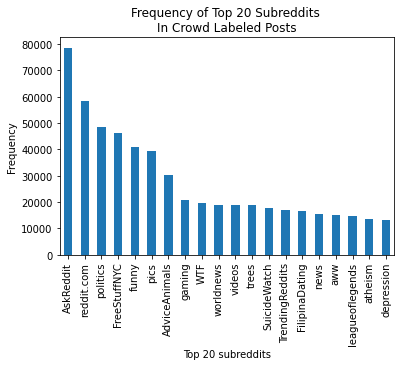

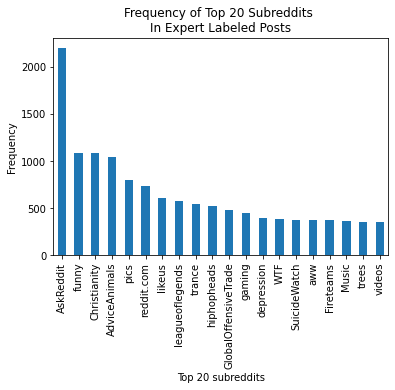

In [ ]:
crowd_posts["subreddit"].value_counts()[:20].plot.bar()
plt.title("Frequency of Top 20 Subreddits \nIn Crowd Labeled Posts")
plt.xlabel("Top 20 subreddits")
plt.ylabel("Frequency")
plt.show()

expert_posts["subreddit"].value_counts()[:20].plot.bar()
plt.title("Frequency of Top 20 Subreddits \nIn Expert Labeled Posts")
plt.xlabel("Top 20 subreddits")
plt.ylabel("Frequency")
plt.show()

We can see the amount of posts we have on each subreddit varies drastically. Only the first 20 are shown above. If we were to include this feature in our model, there may be significant bias towards subreddits with more data (or very little representative data).

### User/Post Distribution

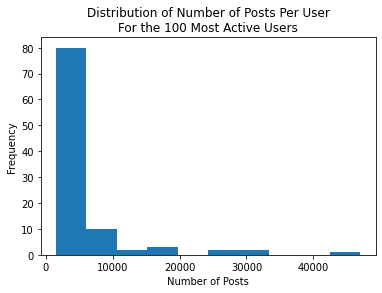

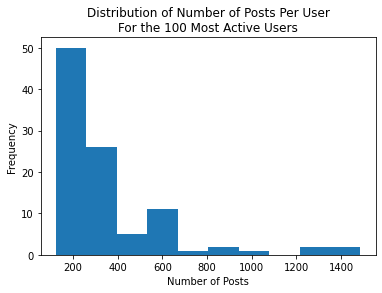

In [ ]:
crowd_posts["user_id"].value_counts()[:100].plot.hist()
plt.xlabel("Number of Posts")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Posts Per User\nFor the 100 Most Active Users")
plt.show()

expert_posts["user_id"].value_counts()[:100].plot.hist()
plt.xlabel("Number of Posts")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Posts Per User\nFor the 100 Most Active Users")
plt.show()

Similarly, the number of posts that users post varies greatly as well. The top 100 most active users are shown in the histograms above. Even in the top 100 users, the number of posts can vary from less than 100 to over 1400 in the expert labeled dataset. This indicates that some users may be overrepresented in the dataset. A simple model may be biased to classify these users correctly.

### Post Text

In [ ]:
import numpy as np

flatten = lambda mat: [e for l in mat for e in l]
crowd_title_words = flatten([e.split() for e in crowd_posts["post_title"] if e == e])
crowd_body_words = flatten([e.split() for e in crowd_posts["post_body"] if e == e])
crowd_title_vocab = set(crowd_title_words)
crowd_body_vocab = set(crowd_body_words)

expert_title_words = flatten([e.split() for e in expert_posts["post_title"] if e == e])
expert_body_words = flatten([e.split() for e in expert_posts["post_body"] if e == e])
expert_title_vocab = set(expert_title_words)
expert_body_vocab = set(expert_body_words)

In [ ]:
print(
    f"""
    There are {len(crowd_title_vocab)} unique words in the titles and 
    {len(crowd_body_vocab)} unique words in the body for the crowd labeled 
    dataset.
    """)

print(
    f"""
    There are {len(expert_title_vocab)} unique words in the titles and 
    {len(expert_body_vocab)} unique words in the body for the crowd labeled 
    dataset.
    """)


    There are 1051222 unique words in the titles and 
    2336311 unique words in the body for the crowd labeled 
    dataset.
    

    There are 78582 unique words in the titles and 
    174417 unique words in the body for the crowd labeled 
    dataset.
    


There is a very large vocab size for both datasets. Treating each word as an individual token could be very costly and may not generalize well to unseen vocabulary. It may make more sense to convert each word into a vector representation using `word2vec`

## Trends

### Do users that are at high risk of sucidality post on certain threads more than others?

In [ ]:
crowd_post_labels = crowd_posts[["user_id", "subreddit"]].drop_duplicates().set_index("user_id").join(
    crowd_meta[["user_id", "high_severity"]].set_index("user_id"), on="user_id", how="inner")

expert_post_labels = expert_posts[["user_id", "subreddit"]].drop_duplicates().set_index("user_id").join(
    expert_meta[["user_id", "high_severity"]].set_index("user_id"), on="user_id", how="inner")

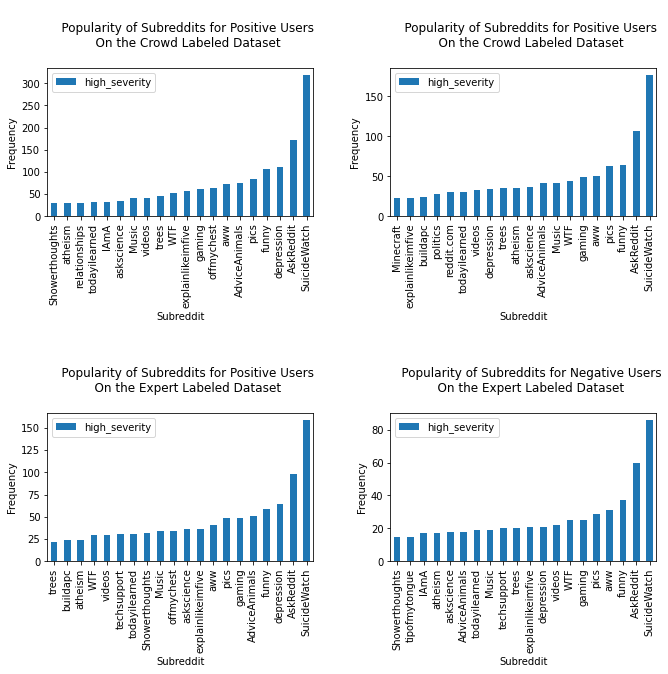

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10, 10))

cpl = crowd_post_labels[crowd_post_labels["high_severity"] == 1]
crowd_top20_threads = cpl.groupby("subreddit").count().sort_values("high_severity").tail(20)
crowd_top20_threads.plot.bar(ax = axs[0][0])
axs[0][0].set_xlabel("Subreddit")
axs[0][0].set_ylabel("Frequency")
axs[0][0].set_title("""
    Popularity of Subreddits for Positive Users
    On the Crowd Labeled Dataset
    """)

cpl = crowd_post_labels[crowd_post_labels["high_severity"] == -1]
crowd_top20_threads = cpl.groupby("subreddit").count().sort_values("high_severity").tail(20)
crowd_top20_threads.plot.bar(ax = axs[0][1])
axs[0][1].set_xlabel("Subreddit")
axs[0][1].set_ylabel("Frequency")
axs[0][1].set_title("""
    Popularity of Subreddits for Positive Users
    On the Crowd Labeled Dataset
    """)

epl = expert_post_labels[expert_post_labels["high_severity"] == 1]
expert_top20_threads = epl.groupby("subreddit").count().sort_values("high_severity").tail(20)
expert_top20_threads.plot.bar(ax = axs[1][0])
axs[1][0].set_xlabel("Subreddit")
axs[1][0].set_ylabel("Frequency")
axs[1][0].set_title("""
    Popularity of Subreddits for Positive Users
    On the Expert Labeled Dataset
    """)

epl = expert_post_labels[expert_post_labels["high_severity"] == -1]
expert_top20_threads = epl.groupby("subreddit").count().sort_values("high_severity").tail(20)
expert_top20_threads.plot.bar(ax = axs[1][1])
axs[1][1].set_xlabel("Subreddit")
axs[1][1].set_ylabel("Frequency")
axs[1][1].set_title("""
    Popularity of Subreddits for Negative Users
    On the Expert Labeled Dataset
    """)

fig.tight_layout(pad=3.0)
plt.show()

We can see that certain threads like `depression` and `offmychest` show up more often for users that have a positive label than those that have a negative label. It may indicate that users that post on SuicideWatch also tend to post on these subreddits.

## Are certain words used more by positively labeled users?

In [ ]:
# clear RAM
del crowd_title_words
del crowd_body_words
del crowd_title_vocab
del crowd_body_vocab

del expert_title_words
del expert_body_words
del expert_title_vocab
del expert_body_vocab

In [ ]:
!wget https://raw.githubusercontent.com/Alir3z4/stop-words/master/english.txt

--2022-12-12 20:17:54--  https://raw.githubusercontent.com/Alir3z4/stop-words/master/english.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7678 (7.5K) [text/plain]
Saving to: ‘english.txt’

english.txt         100%[===================>]   7.50K  --.-KB/s    in 0.004s  

2022-12-12 20:17:55 (1.68 MB/s) - ‘english.txt’ saved [7678/7678]



In [ ]:
crowd_posts["text"] = crowd_posts["post_title"] + " " + crowd_posts["post_body"] 

In [ ]:
user_titles = crowd_posts[["user_id", "post_title"]].dropna()
user_titles = user_titles.set_index("user_id")
user_titles = user_titles.join(crowd_meta[["user_id", "high_severity"]]
                               .set_index("user_id"), on="user_id", how="inner")
user_titles = user_titles.reset_index().set_index(["user_id", "high_severity"])
user_words = user_titles.apply(lambda column: column.str.split().explode())
user_words = user_words.reset_index().drop(columns=["user_id"])
user_words.head()

,high_severity,post_title
0,-1,[real]
1,-1,motivation
2,-1,simple
3,-1,question
4,-1,about


In [ ]:
stop_words = open("english.txt").read().split('\n')
stop_words += ["-", "[discussion]", "_person_", "_person_,", "_person_?", 
               "reddit", "reddit,", "_person_.", "[h]", "[w]"]
bool_idx = [word.lower() not in stop_words for word in user_words["post_title"]]

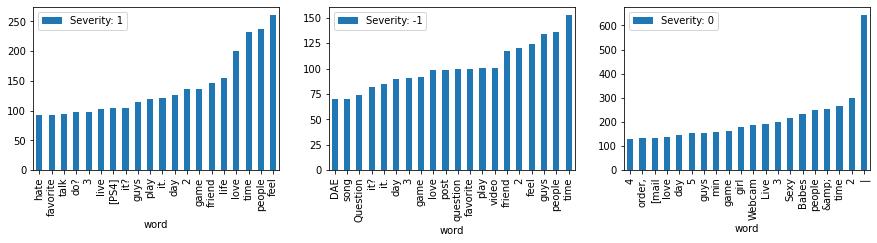

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

for i, severity in enumerate([1, -1, 0]):
    user_words[bool_idx & (user_words["high_severity"] == severity)].groupby(
        "post_title").count().reset_index().sort_values(by="high_severity").rename(
            columns={"high_severity": f"Severity: {severity}", "post_title": "word"}
        ).tail(20).set_index("word").plot.bar(ax=axs[i])
plt.show()

We can see that there are certain words that are more popular for both positive and negative labeled (1 and -1) users than control users (0). This may indicate that there are words that can help a model separate titles that belong to SuicideWatch from other threads. This would provide an easy (albeit incorrect) signal to a trained model that a user may be positvely labeled for suicidality. 

We can also see that between positve and negative labeled users, there are differences in the most popular words. "Feel" and "love" are ranked higher for positvely labeled users; "hate" and "live" also show up quite often as well. While these may be words that are used more often by a positively labeled user, a model that is trained on this dataset may be tricked by well-crafted text such as:

```
I currently live in College Park Maryland! I love the campus but feel that the weather is quite unpredictable. I hate when it gets super cold, but hate it even more when it flips between hot and cold on a daily basis.
```

My (unprofessional) opinion: -1, this user is not suicidal

A potential model's prediction: 1, this user is suicidal